## Explore data and analysis.

Here we will reproduce a figure from the manuscript. We will start by loading and analyzing some files. We will then make some plots.

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt  # just to show plots during script
import seaborn as sns

import sanpy

from sanpy.sanpyLogger import get_logger
logger = get_logger(__name__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load some sample data.

`jupyter notebook` needs to be run from SanPy/ folder

In [13]:

# list of files to analyze
aDict = {
    '19503001': {
        'path': 'data/laura-iso-manuscript/19503001.abf',
        'detectionType': 'dvdt',
        'dvdtThreshold': 60,  # chosen by visual inspection
        'controlSec': [10, 90],
        'isoSec': [210, 300],
    },
    '19503006': {
        'path': 'data/laura-iso-manuscript/19503006.abf',
        'detectionType': 'dvdt',
        'dvdtThreshold': 18,  # chosen by visual inspection
        'controlSec': [10, 90],
        'isoSec': [180, 270],
    },
    '20191122_0001': {
        # IMPORTANT: The recording chagegd too much in this recording !!!!
        # these changes are not due to ISO and in opposite direction from expected (which is good)!!!
        'path': 'data/laura-iso-manuscript/20191122_0001.abf',
        'detectionType': 'mv',
        #'dvdtThreshold': 50,
        'mvThreshold': -40,
        'controlSec': [10, 90],
        'isoSec': [380, 470],
    },
}

In [14]:
# load each file and perform spike detection

# todo: split this into (i) loading which is dead simple and then (ii) creating pandas dataframes
# return to API to make creation of pooled dataframes more simpe

baList = []
dfList = []
dfMaster = None
for idx, (file, params) in enumerate(aDict.items()):

    filePath = params['path']
    detectionType = params['detectionType']
    controlSec = params['controlSec']
    isoSec = params['isoSec']

    # load
    ba = sanpy.bAnalysis(filePath)
    baList.append(ba)
    
    # analyze spikes
    detectionClass = ba.detectionClass  # Default detection values
    detectionClass['verbose'] = False
    if detectionType == 'dvdt':
        detectionClass['detectionType'] = sanpy.bDetection.detectionTypes.dvdt
    elif detectionType == 'mv':
        detectionClass['detectionType'] = sanpy.bDetection.detectionTypes.mv
    ba.spikeDetect(detectionClass)

    # grab results as a pandas dataframe
    df = ba.asDataFrame()

    # todo: merge into big dataframe, add column 'myCellNumber'

    # pull control versus drug stats based on time
    # could do this as well
    #thresholdSec = ba.getStat('thresholdSec', asArray=True)

    # boolean mask based on a time window
    thresholdSec = df['thresholdSec']
    controlMask = (thresholdSec>controlSec[0]) & (thresholdSec<controlSec[1])
    isoMask = (thresholdSec>isoSec[0]) & (thresholdSec<isoSec[1])

    df['myCondition'] = 'None'
    df['myCondition'] = np.where(controlMask, 'Control', df['myCondition'])
    df['myCondition'] = np.where(isoMask, 'Iso', df['myCondition'])

    # Remove .abf from 'file'
    df['myFile'] = df['file'].replace('.abf', '')
    
    if dfMaster is None:
        dfMaster = df
    else:
        dfMaster.append(df, ignore_index=True)
        
    dfList.append(df)
    
    # drop any remaining datapoint (rows) with myCondition == 'None'
    dfPlot = df.drop(df[df['myCondition'] == 'None'].index)


ERROR sanpy.bAnalysis_  bAnalysis_.py __init__() line:152 -- File does not exist: "data/laura-iso-manuscript/19503001.abf"


AttributeError: 'NoneType' object has no attribute 'sweepX'

In [11]:
statName = 'widths_50'

palette_muted = {
    "Control": "#222222",
    "Iso": "#dd1111",
    "None": "#dddddd",
    }
palette = {
    "Control": "k",
    "Iso": "r",
    "None": "#dddddd",
    }


In [51]:
# work on one ba
ba = baList[0]
filename = ba.getFileName()
oneDf = dfList[0]

(<Figure size 648x216 with 1 Axes>, <AxesSubplot:xlabel="sec'", ylabel='mV'>)

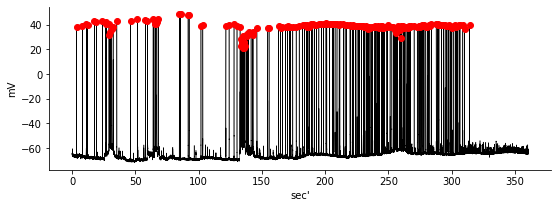

In [52]:
bap = sanpy.bAnalysisPlot(ba)
bap.plotSpikes(plotThreshold=False, plotPeak=True)

<AxesSubplot:xlabel="sec'", ylabel='mV'>

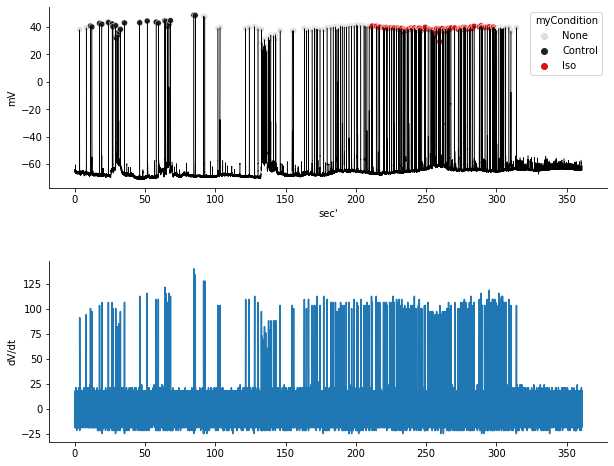

In [56]:
# plot raw the vm and dvdt
bap = sanpy.bAnalysisPlot(ba)  # A plot object that provides different kinds of plots
fig, axs = bap.plotDerivAndRaw()

# overlay detected spikes on vm
# see the following for full list of names and meaning of detected parameters
# https://cudmore.github.io/SanPy/methods/#analysis-output
statName = 'thresholdVal'
statName = 'peakVal'
sns.scatterplot(x='thresholdSec', y=statName, hue='myCondition', palette=palette_muted, data=oneDf, ax=axs[0])



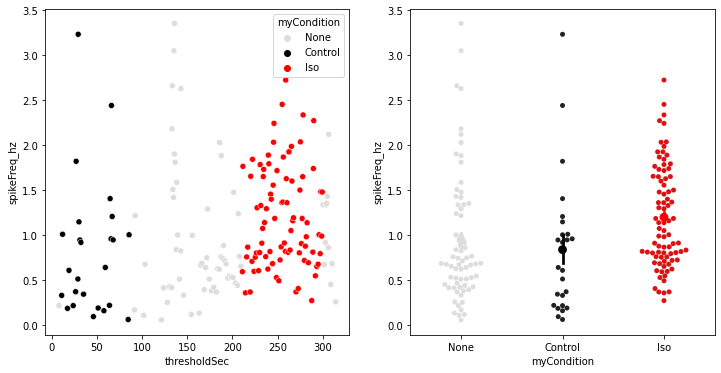

In [63]:
statName = 'spikeFreq_hz'
#statName = 'widths_50'
#statName = 'thresholdVal'

fig, axs = plt.subplots(1,2, figsize=(12,6))

# as a time-series
myScatter = sns.scatterplot(x='thresholdSec', y=statName, hue='myCondition', palette=palette, data=oneDf, ax=axs[0])

# as a category
#sns.catplot(x="myCondition", y=statName, kind="swarm", data=dfPlot)

mySwarm = sns.swarmplot(x='myCondition', y=statName, palette=palette_muted, data=oneDf, zorder=1, ax=axs[1])
myPoint = sns.pointplot(x='myCondition', y=statName, palette=palette, data=oneDf, ci=68, ax=axs[1])



In [48]:
# show some summary statistics between groups
aggDict = {
    statName: ['min', 'max', 'mean', 'sem', 'count'],
}

oneDf.groupby(['myCondition']).agg(aggDict)


thresholdVal                                      
                     min        max       mean       sem count
myCondition                                                   
Control       -56.610107 -37.384033 -43.609619  0.849254    25
Iso           -66.680908 -37.231445 -43.156942  0.634626    84
None          -68.664551 -37.689209 -44.564510  0.839514    69

In [49]:
# do statistics
# for now we are just doing a t-test, we may be breaking a lot of assumptions! Left as a homewok assignment.

condition = 'Control'
controlRows = oneDf[ oneDf['myCondition']==condition] 
controlValues = controlRows[statName].tolist()
print('Control n=', len(controlValues))

condition = 'Iso'
isoRows = oneDf[ oneDf['myCondition']==condition] 
isoValues = isoRows[statName].tolist()
print('Iso n=', len(isoValues))

import scipy.stats

print('statName:', statName)
test_t, ttest_p = scipy.stats.ttest_ind(a=controlValues, b=isoValues, equal_var=True)
print(test_t, ttest_p)

kw_h, kw_p = scipy.stats.kruskal(controlValues, isoValues)
print(kw_h, kw_p)


Control n= 25
Iso n= 84
statName: thresholdVal
-0.361041115179633 0.7187805673527631
3.044105237850161 0.08103075748422309


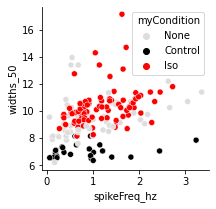

In [61]:
# plot two stats (similar to thresholdSec above)
xStat = 'spikeFreq_hz'
yStat = 'widths_50'

fig, axs = plt.subplots(1,1, figsize=(3,3))
axs = [axs]

# as a time-series
myScatter = sns.scatterplot(x=xStat, y=yStat, hue='myCondition', palette=palette, data=oneDf, ax=axs[0])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
